<a href="https://colab.research.google.com/github/milalangone/kidney_segmentation/blob/main/TP_PIB_LangoneRondinellaSimoncelliTerrazas.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Procesamiento y clasificación de tumores, quistes y cálculos renales

(2Q2023) 16.16 - Procesamiento de Imágenes Biomédicas

**Alumnas:**

- Mila Langone (61273)
- Francesca Rondinella (61031)
- Lucía Simoncelli (61429)
- Shirley Terrazas (59471)

## Introducción

En el presente proyecto se propone la clasificación de distintas patologías renales (quistes, tumores y cálculos) y de riñones sanos a partir de tomografías de corte coronal. El objetivo es diseñar una herramienta de decisión clínica prometedora, que apunta hacia la detección temprana y el diagnóstico preciso de diversas afecciones renales. De este modo, se promueve el tratamiento temprano y se previenen complicaciones asociadas (como dolor, ruptura de quistes/cálculos, metástasis, obstrucción del flujo de orina, entre otras).

Se utilizará una interfaz gráfica, donde el usuario carga una imagen de tomografía y luego selecciona según que método de segmentación desea que se analice su imagen. Luego, la clasificación se realiza mediante algoritmos de *Machine Learning *(ML), que emergen como una solución eficiente a la problemática planteada. Este sistema no solo agiliza el proceso de diagnóstico, sino que también mejora la precisión y la consistencia en la identificación de patologías, contribuyendo así a una atención médica más efectiva.

Se utilizará un [dataset de Kaggle](https://www.kaggle.com/datasets/nazmul0087/ct-kidney-dataset-normal-cyst-tumor-and-stone/), que posee más de 2000 imágenes para cada clase (menos para cálculos que posee alrededor de 1000), y un archivo csv asociado donde se marcan dichas imágenes según la patología.

## Preliminares

### Importación de librerías

In [1]:
import numpy as np
import cv2
import os
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('dark_background')

import seaborn as sns
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import train_test_split, cross_val_score, HalvingRandomSearchCV, RandomizedSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm, metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.datasets import make_classification
from imblearn.over_sampling import SMOTE
from collections import Counter
from scipy.stats import randint, uniform

In [2]:
!pip install SimpleITK
import SimpleITK as sitk

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.7/52.7 MB 19.7 MB/s eta 0:00:00


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Funciones Auxiliares

In [4]:
def plot_imgs(item_dir, num_imgs=25):

    all_item_dirs = os.listdir(item_dir)
    item_files = [os.path.join(item_dir, file) for file in all_item_dirs][:num_imgs]

    plt.figure(figsize=(10, 10))
    for idx, img_path in enumerate(item_files):
        plt.subplot(5, 5, idx+1)
        img = plt.imread(img_path)
        plt.title(f'{img_path}'[-10:-4])
        plt.imshow(img)

    plt.tight_layout()

## Inspección de datos

Inicialmente, se observan los contenidos de las carpetas de las distintas imágenes y se inspecciona el archivo csv a través de distintas funciones de la biblioteca Pandas.

### Inspección .csv

Se observa que cada imagen está etiquetada según su patología, y que se encuentran un 50% más de tomografías de riñones sanos con respecto a cada una del resto de las clases.

In [ ]:
path = '/content/drive/MyDrive/TP PIB/archive'
file_name = 'kidneyData.csv'

df = pd.read_csv(os.path.join(path, file_name))

In [ ]:
df.head()

,Unnamed: 0,image_id,path,diag,target,Class
0,0,Tumor- (1044),"/content/data/CT KIDNEY DATASET Normal, CYST, ...",Tumor,3,Tumor
1,1,Tumor- (83),"/content/data/CT KIDNEY DATASET Normal, CYST, ...",Tumor,3,Tumor
2,2,Tumor- (580),"/content/data/CT KIDNEY DATASET Normal, CYST, ...",Tumor,3,Tumor
3,3,Tumor- (1701),"/content/data/CT KIDNEY DATASET Normal, CYST, ...",Tumor,3,Tumor
4,4,Tumor- (1220),"/content/data/CT KIDNEY DATASET Normal, CYST, ...",Tumor,3,Tumor


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12446 entries, 0 to 12445
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  12446 non-null  int64 
 1   image_id    12446 non-null  object
 2   path        12446 non-null  object
 3   diag        12446 non-null  object
 4   target      12446 non-null  int64 
 5   Class       12446 non-null  object
dtypes: int64(2), object(4)
memory usage: 583.5+ KB


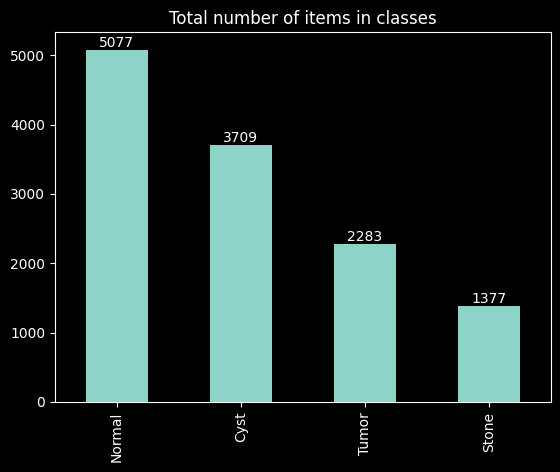

In [ ]:
kidney_classes = df['Class'].value_counts()

plot_bar = kidney_classes.plot.bar(title='Total number of items in classes')
plot_bar.bar_label(plot_bar.containers[0]);

### Inspección de imágenes

Para comenzar, se plotean cinco imágenes de cada sub-grupo a modo de familiarización con las patologías a reconocer:

In [ ]:
path = '/content/drive/MyDrive/TP PIB/archive/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/'
path_cysts = '/content/drive/MyDrive/TP PIB/archive/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/Cyst'
path_stones = '/content/drive/MyDrive/TP PIB/archive/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/Stone'
path_normal = '/content/drive/MyDrive/TP PIB/archive/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/Normal'
path_tumor = '/content/drive/MyDrive/TP PIB/archive/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/Tumor'
path_prueba = '/content/drive/MyDrive/TP PIB/archive/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/Prueba'

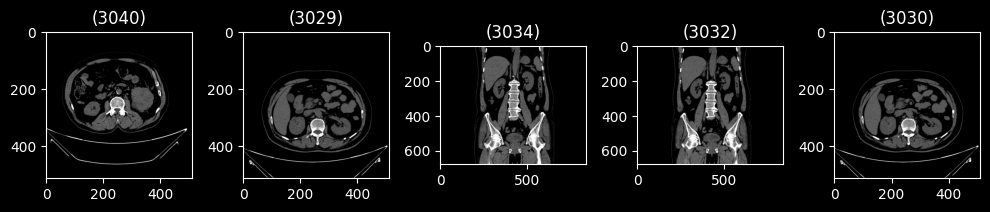

In [ ]:
# Imágenes quistes
plot_imgs(path_cysts, 5)

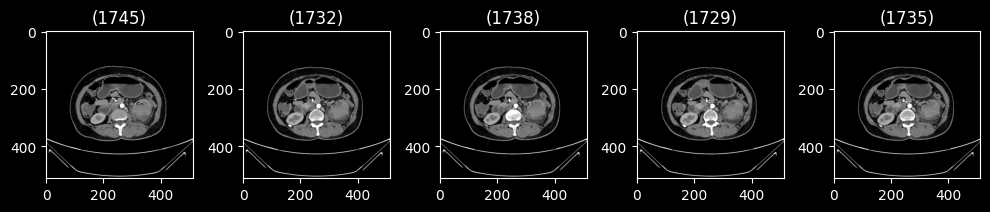

In [ ]:
# Imagenes tumores
plot_imgs(path_tumor, 5)

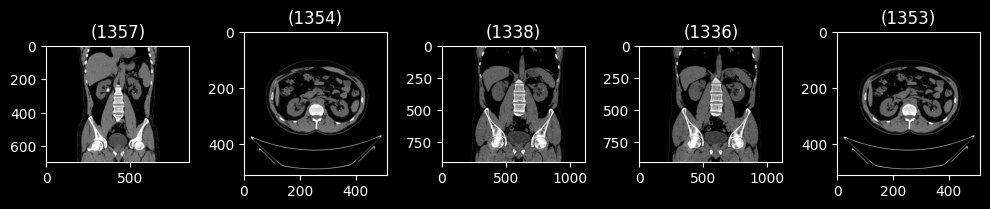

In [ ]:
# Imágenes cálculos
plot_imgs(path_stones, 5)

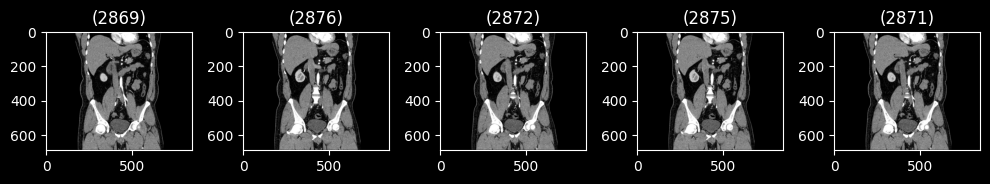

In [ ]:
# Imagenes no patológicas
plot_imgs(path_normal, 5)

Luego de examinar los archivos que se encontraban en las carpetas se observó que las imágenes son secuencias/ráfagas de cortes coronales y transversales de un mismo paciente a distintas profundidades. Por lo tanto, mucha de la información es redundante o irrelevante por no mostrar los riñones, es decir la estructura de interés.

Por este motivo, se decidió conservar para el análisis solamente las tomografías del plano coronal a una profundidad tal que corte a los riñones en su plano medio para maximizar la superficie visualizada.

A continuación se analiza un histograma de cada una de las categorías para ver si se encuentra algún patrón consistente con ruido sal y pimienta o gaussiano:

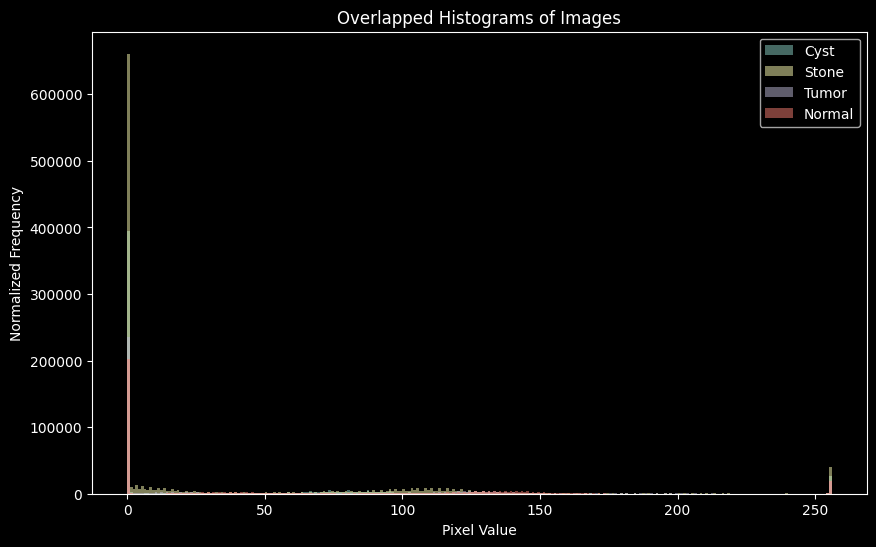

In [ ]:
def plot_overlapped_histograms(images, labels, flag = True):

  plt.figure(figsize=(10, 6))

  for i, image_path in enumerate(images):
    image = cv2.imread(image_path, 0)
    hist, bins = np.histogram(image.ravel(), bins=256, range=(0, 256))
    hist = hist / hist.sum()
    if flag:
      plt.hist(image.ravel(), bins=256, range=(0, 256), alpha=0.5, label=labels[i])
    else:
      plt.hist(image.ravel(), bins=256, range=(1, 256), alpha=0.5, label=labels[i])
      print(labels[i], ': negro', hist[0], ', blanco:', hist[255])

  plt.xlabel('Pixel Value')
  plt.ylabel('Normalized Frequency')
  plt.legend()
  plt.title('Overlapped Histograms of Images')
  plt.show()


image_paths = [f'{path_cysts}/Cyst- (705).jpg', f'{path_stones}/Stone- (86).jpg', f'{path_tumor}/Tumor- (185).jpg', f'{path_normal}/Normal- (171).jpg']
labels = ['Cyst', 'Stone', 'Tumor', 'Normal']

plot_overlapped_histograms(image_paths, labels)

Dado que el histograma no queda a escala por la alta presencia de píxeles negros, se lo vuelve a graficar sin el valor inicial. Además, se calcula la proporción de píxeles blancos y negros presentes en la imagen.

Cyst : negro 0.648253180511245 , blanco: 0.04262672811059908
Stone : negro 0.5341567817295972 , blanco: 0.031870233326544005
Tumor : negro 0.49649197743362455 , blanco: 0.04141750331982847
Normal : negro 0.4511025886864813 , blanco: 0.040997569622511096


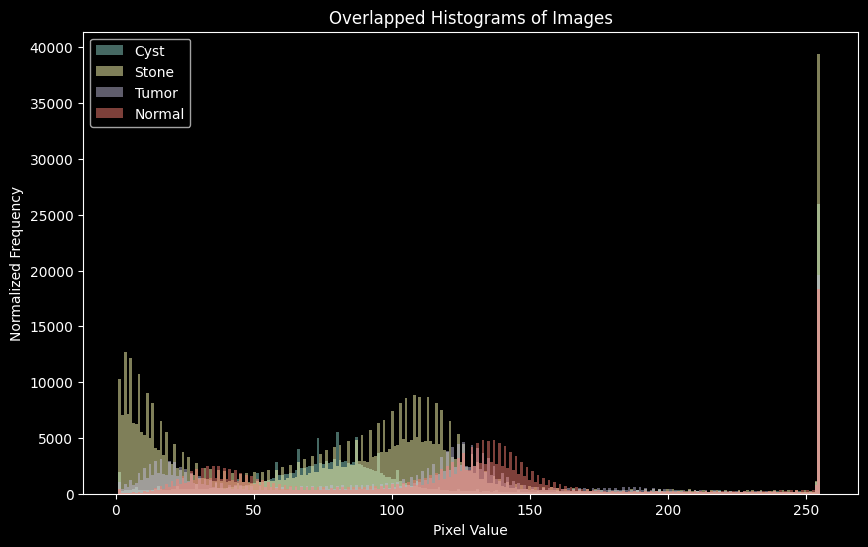

In [ ]:
plot_overlapped_histograms(image_paths, labels, False)

Observando la proporción de píxeles blancos y negros, se concluye que las imágenes no tienen ruido sal y pimienta. Por otro lado, ninguno de los histogramas presenta una morfología de campana de Gauss pura, pero a simple vista las imágenes parecieran tener ruido gaussiano. Por lo tanto, se aplicará un filtro gaussiano.

Se concluye además que todas las imágenes presentarán comportamientos similares inferidos a partir del primer muestreo y de la observación de las imágenes de la carpeta.

## Mejoramiento

A continuación se aplica un filtro gaussiano a todas las imágenes a analizar con la finalidad de mejorarlas para su posterior segmentación. Estas luego se utilizarán para entrenar los algoritmos de ML.

Cuando el usuario ingrese una imagen en la interfaz, esta se mejorará automáticamente.

In [ ]:
path_cysts_filt = '/content/drive/MyDrive/TP PIB/archive/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/Cyst filtrado'
path_stones_filt = '/content/drive/MyDrive/TP PIB/archive/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/Stone filtrado'
path_normal_filt = '/content/drive/MyDrive/TP PIB/archive/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/Normal filtrado'
path_tumor_filt = '/content/drive/MyDrive/TP PIB/archive/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/Tumor filtrado'

In [6]:
def gaussian(img_path, kernel_size, sigma):
  filtered = []
  all_item_dirs = os.listdir(img_path)
  item_files = [os.path.join(img_path, file) for file in all_item_dirs]

  for idx, img_path in enumerate(item_files):
    image = cv2.imread(img_path, 0)
    filt_img = cv2.GaussianBlur(image, (kernel_size, kernel_size), sigma)
    filtered.append(filt_img)
  return filtered

In [ ]:
filtered_normal = gaussian(path_normal_filt, 5, 1)
filtered_cysts = gaussian(path_cysts_filt, 5, 1)
filtered_tumor = gaussian(path_tumor_filt, 5, 1)
filtered_stones = gaussian(path_stones_filt, 5, 1)

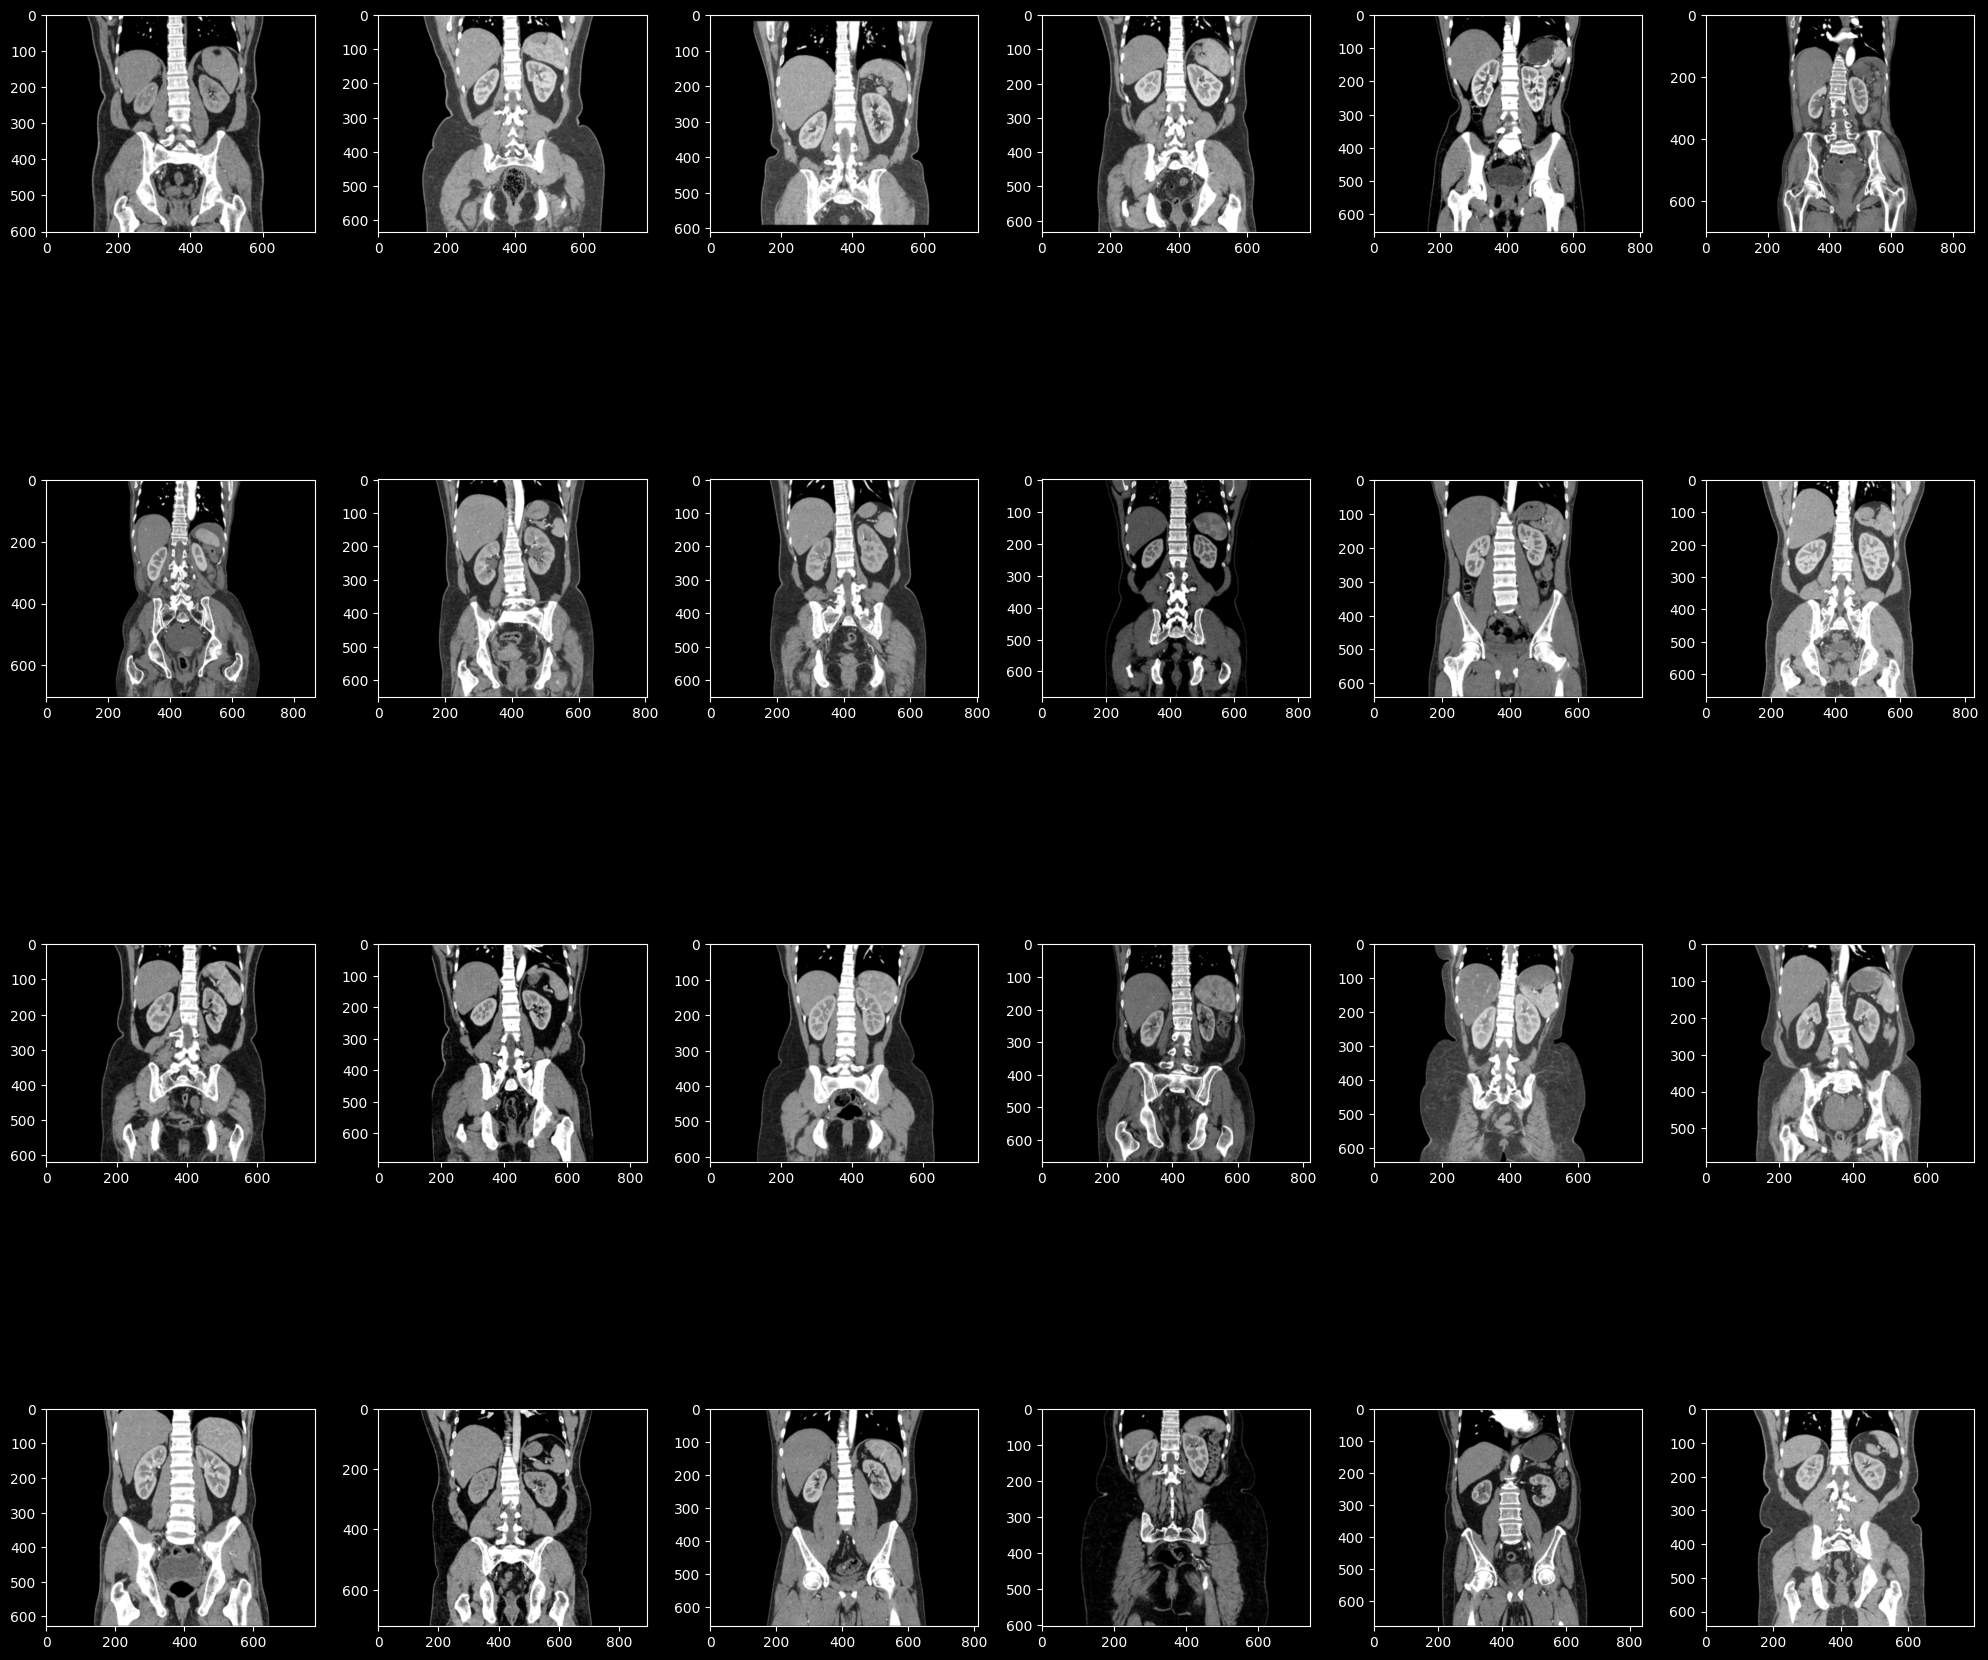

In [ ]:
plt.figure(figsize=(20, 20))

for idx, img in enumerate(filtered_normal):
  plt.subplot(4,6,idx+1)
  plt.imshow(img, cmap = 'gray', vmin = 0, vmax = 255)

plt.tight_layout()
plt.show()

##Segmentación

A continuación se halla la función de segmentación, que tiene como objetivo delimitar correctamente los riñones. Esta utiliza el método elegido por el usuario en la interfaz (Otsu, K-Means o Watershed), y genera las imágenes pertinentes para el posterior análisis de texturas.

In [5]:
def segmentar(img, select):
  img_new = np.zeros((len(img), len(img[0])))

  # select = [0, 1, 2] = [otsu, km, watershed]
  if select == 0:
      _, img_otsu = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
      return img_otsu
  elif select == 1:
      # Convert image to float32 and flatten
      z = img.astype(np.float32).reshape((-1, 1))

      criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
      flags = cv2.KMEANS_RANDOM_CENTERS

      compactness, labels, centers = cv2.kmeans(z, 2, None, criteria, 10, flags)
      center = np.uint8(centers)
      img_kmeans = center[labels.flatten()]
      img_kmeans = img_kmeans.reshape((img.shape))
      return img_kmeans
  elif select == 2:
      # Convert the image to a SimpleITK image
      sitk_image = sitk.GetImageFromArray(img)

      # Apply the Morphological Watershed algorithm
      ws_img = sitk.MorphologicalWatershed(sitk_image, level=0, markWatershedLine=True, fullyConnected=True)

      # Convert the result back to a NumPy array
      img_ws = sitk.GetArrayFromImage(ws_img)
      return img_ws

In [7]:
def bin2gray(img_seg, img_og):

  img_new = np.zeros((len(img_seg), len(img_seg[0])))
  for i in range(len(img_seg)):
    for j in range(len(img_seg[0])):
      if img_seg[i][j] != 0:
        img_new[i][j] = img_og[i][j]
  return img_new.astype(np.uint8)

In [8]:
def clicker_seg(img_r1, img_r2, select):
  img_seg1 = segmentar(img_r1, select)
  img_seg2 = segmentar(img_r2, select)
  img_gray1 = bin2gray(img_r1)
  img_gray2 = bin2gray(img_r2)
  return img_gray1, img_gray2

In [ ]:
prueba = filtered_normal[0]
img_seg_o = segmentar(prueba, 0)
prueba_seg = segmentar(img_seg_o, 1)
prueba_seg_gray = bin2gray(prueba_seg, prueba)

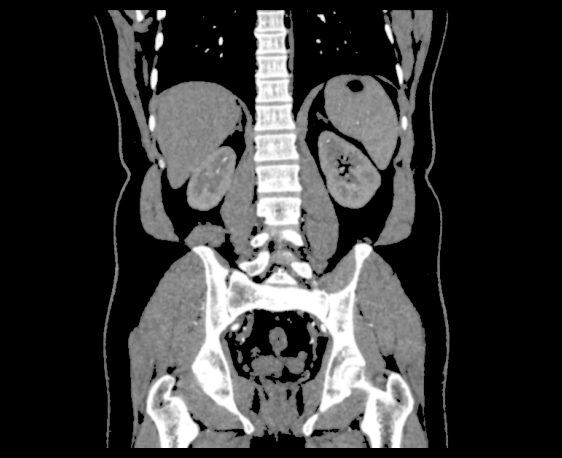

In [ ]:
plt.figure(figsize=(7,7))
plt.imshow(prueba_seg_gray, cmap="gray",vmin=0, vmax=255)
# plt.imshow(prueba_seg, cmap="gray",vmin=0, vmax=255)
plt.axis('off')
plt.show()

Comprobado que funciona, vamos a segmentar el resto de las imagenes.

In [ ]:
filtered_paths = [filtered_tumor, filtered_cysts, filtered_stones, filtered_normal]

segmented_tumor = []
segmented_cysts = []
segmented_stones = []
segmented_normal = []

segmented_paths = [segmented_tumor, segmented_cysts, segmented_stones, segmented_normal]


for i in range(len(filtered_paths)):
  for img in filtered_paths[i]:
    img_seg_kmeans = segmentar(img, 1)
    seg_gray = bin2gray(img_seg_kmeans, img)
    segmented_paths[i].append(seg_gray)


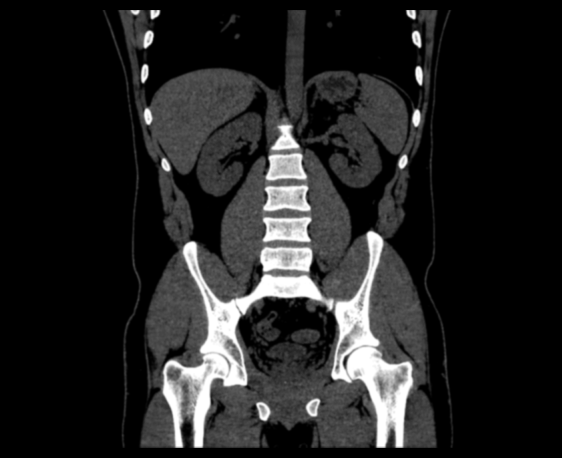

In [ ]:
plt.figure(figsize=(7,7))
plt.imshow(segmented_stones[3], cmap="gray",vmin=0, vmax=255)
# plt.imshow(prueba_seg, cmap="gray",vmin=0, vmax=255)
plt.axis('off')
plt.show()

## Extracción de Features
En este paso se extraen las características o *features* pertinentes para la clasificación de las distintas afecciones.

### Análisis de texturas

Los análisis de texturas se basan sobre el cálculo de la matriz de co-ocurrencia en las cuatro direcciones.

In [9]:
from skimage import feature
from scipy.stats import skew, kurtosis
from skimage.measure import shannon_entropy
from skimage.feature import graycomatrix, graycoprops
from skimage.measure import regionprops
from skimage.transform import integral_image
from skimage.feature import local_binary_pattern

In [10]:
def extract_intensity_features(image):
    intensity_features = {}
    intensity_features['mean_intensity'] = np.mean(image)
    intensity_features['max_value'] = np.max(image)
    intensity_features['std_intensity'] = np.std(image)
    intensity_features['skewness'] = skew(image.flatten())
    intensity_features['kurtosis'] = kurtosis(image.flatten())
    return intensity_features

def extract_texture_features(image):
    texture_features = {}

    glcm = graycomatrix(image, [1], [0], symmetric=True, normed=True)
    texture_features['contrast'] = graycoprops(glcm, 'contrast')[0, 0]
    texture_features['homogeneity'] = graycoprops(glcm, 'homogeneity')[0, 0]
    texture_features['energy'] = graycoprops(glcm, 'energy')[0, 0]
    texture_features['correlation'] = graycoprops(glcm, 'correlation')[0, 0]
    texture_features['dissimilarity'] = graycoprops(glcm, 'dissimilarity')[0, 0]

    return texture_features

def extract_features(image):
    features = {}

    intensity_features = extract_intensity_features(image)
    texture_features = extract_texture_features(image)

    features.update(intensity_features)
    features.update(texture_features)

    return features

def create_dataframe(path, label):

    data = []
    # img_files = [os.path.join(path, f) for f in os.listdir(path) if f.endswith('.jpg')]

    for img in path:
        # img = cv2.imread(img, cv2.IMREAD_GRAYSCALE)

        features = extract_features(img)
        features['label'] = label

        data.append(features)

    df = pd.DataFrame(data)

    return df

##Data Augmentation

In [11]:
labels = ['Tumor', 'Cyst', 'Stones', 'Normal']

path_cysts_cut = '/content/drive/MyDrive/TP PIB/archive/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/kidneys/cysts'
path_stones_cut = '/content/drive/MyDrive/TP PIB/archive/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/kidneys/stones'
path_normal_cut = '/content/drive/MyDrive/TP PIB/archive/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/kidneys/normal'
path_tumor_cut = '/content/drive/MyDrive/TP PIB/archive/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/kidneys/tumor'

paths_cut = [path_cysts_cut,path_stones_cut,path_normal_cut,path_tumor_cut]

In [ ]:
def flip_images_in_directory(input_directory, flip_direction='horizontal'):
  files = os.listdir(input_directory)
  for file in files:
    file_path = os.path.join(input_directory, file)
    original_image = cv2.imread(file_path)
    if flip_direction == 'horizontal':
      flipped_image = cv2.flip(original_image, 1)
    elif flip_direction == 'vertical':
      flipped_image = cv2.flip(original_image, 0)

    output_path, ext = os.path.splitext(file_path)
    output_path = f"{output_path}_flipped_{flip_direction}{ext}"
    cv2.imwrite(output_path, flipped_image)

In [ ]:
for path in paths_cut:
  flip_images_in_directory(path, flip_direction = 'horizontal')
  flip_images_in_directory(path, flip_direction = 'vertical')

In [12]:
filtered_normal_cut = gaussian(path_normal_cut, 5, 1)
filtered_cysts_cut = gaussian(path_cysts_cut, 5, 1)
filtered_tumor_cut = gaussian(path_tumor_cut, 5, 1)
filtered_stones_cut = gaussian(path_stones_cut, 5, 1)

paths_cut_filtered = [filtered_tumor_cut, filtered_cysts_cut, filtered_stones_cut, filtered_normal_cut]

In [13]:
segmented_tumor = []
segmented_cysts = []
segmented_stones = []
segmented_normal = []

segmented_paths = [segmented_tumor, segmented_cysts, segmented_stones, segmented_normal]

for i in range(len(paths_cut_filtered)):
  for img in paths_cut_filtered[i]:
    img_seg_kmeans = segmentar(img, 1)
    seg_gray = bin2gray(img_seg_kmeans, img)
    segmented_paths[i].append(seg_gray)

In [14]:
dfs = []

for path, label in zip(segmented_paths,labels):
    df_by_label = create_dataframe(path, label)
    dfs.append(df_by_label)

df = pd.concat(dfs, ignore_index = True)

In [ ]:
df.describe()

,mean_intensity,max_value,std_intensity,skewness,kurtosis,contrast,homogeneity,energy,correlation,dissimilarity
count,368.000000,368.000000,368.000000,368.000000,368.000000,368.000000,368.000000,368.000000,368.000000,368.000000
mean,83.673085,223.815217,42.873160,-0.170553,0.375046,30.884678,0.358788,0.100369,0.991859,3.360249
std,33.802673,52.990962,9.513543,0.667558,2.414237,19.598490,0.094789,0.097017,0.003371,1.115106
min,22.881264,83.000000,22.907023,-1.517550,-1.761676,5.646132,0.200726,0.018579,0.981933,1.448655
25%,55.540293,215.750000,36.489304,-0.550804,-1.150377,16.873379,0.277221,0.029193,0.989465,2.470700
50%,72.032241,255.000000,42.864098,-0.325741,-0.330895,22.680007,0.349905,0.053831,0.992327,2.976793
75%,114.666165,255.000000,49.436247,0.226013,0.927474,43.450820,0.423858,0.146363,0.994449,4.205939
max,153.411793,255.000000,65.209086,2.040146,11.204322,96.108347,0.581616,0.385708,0.997490,6.424075


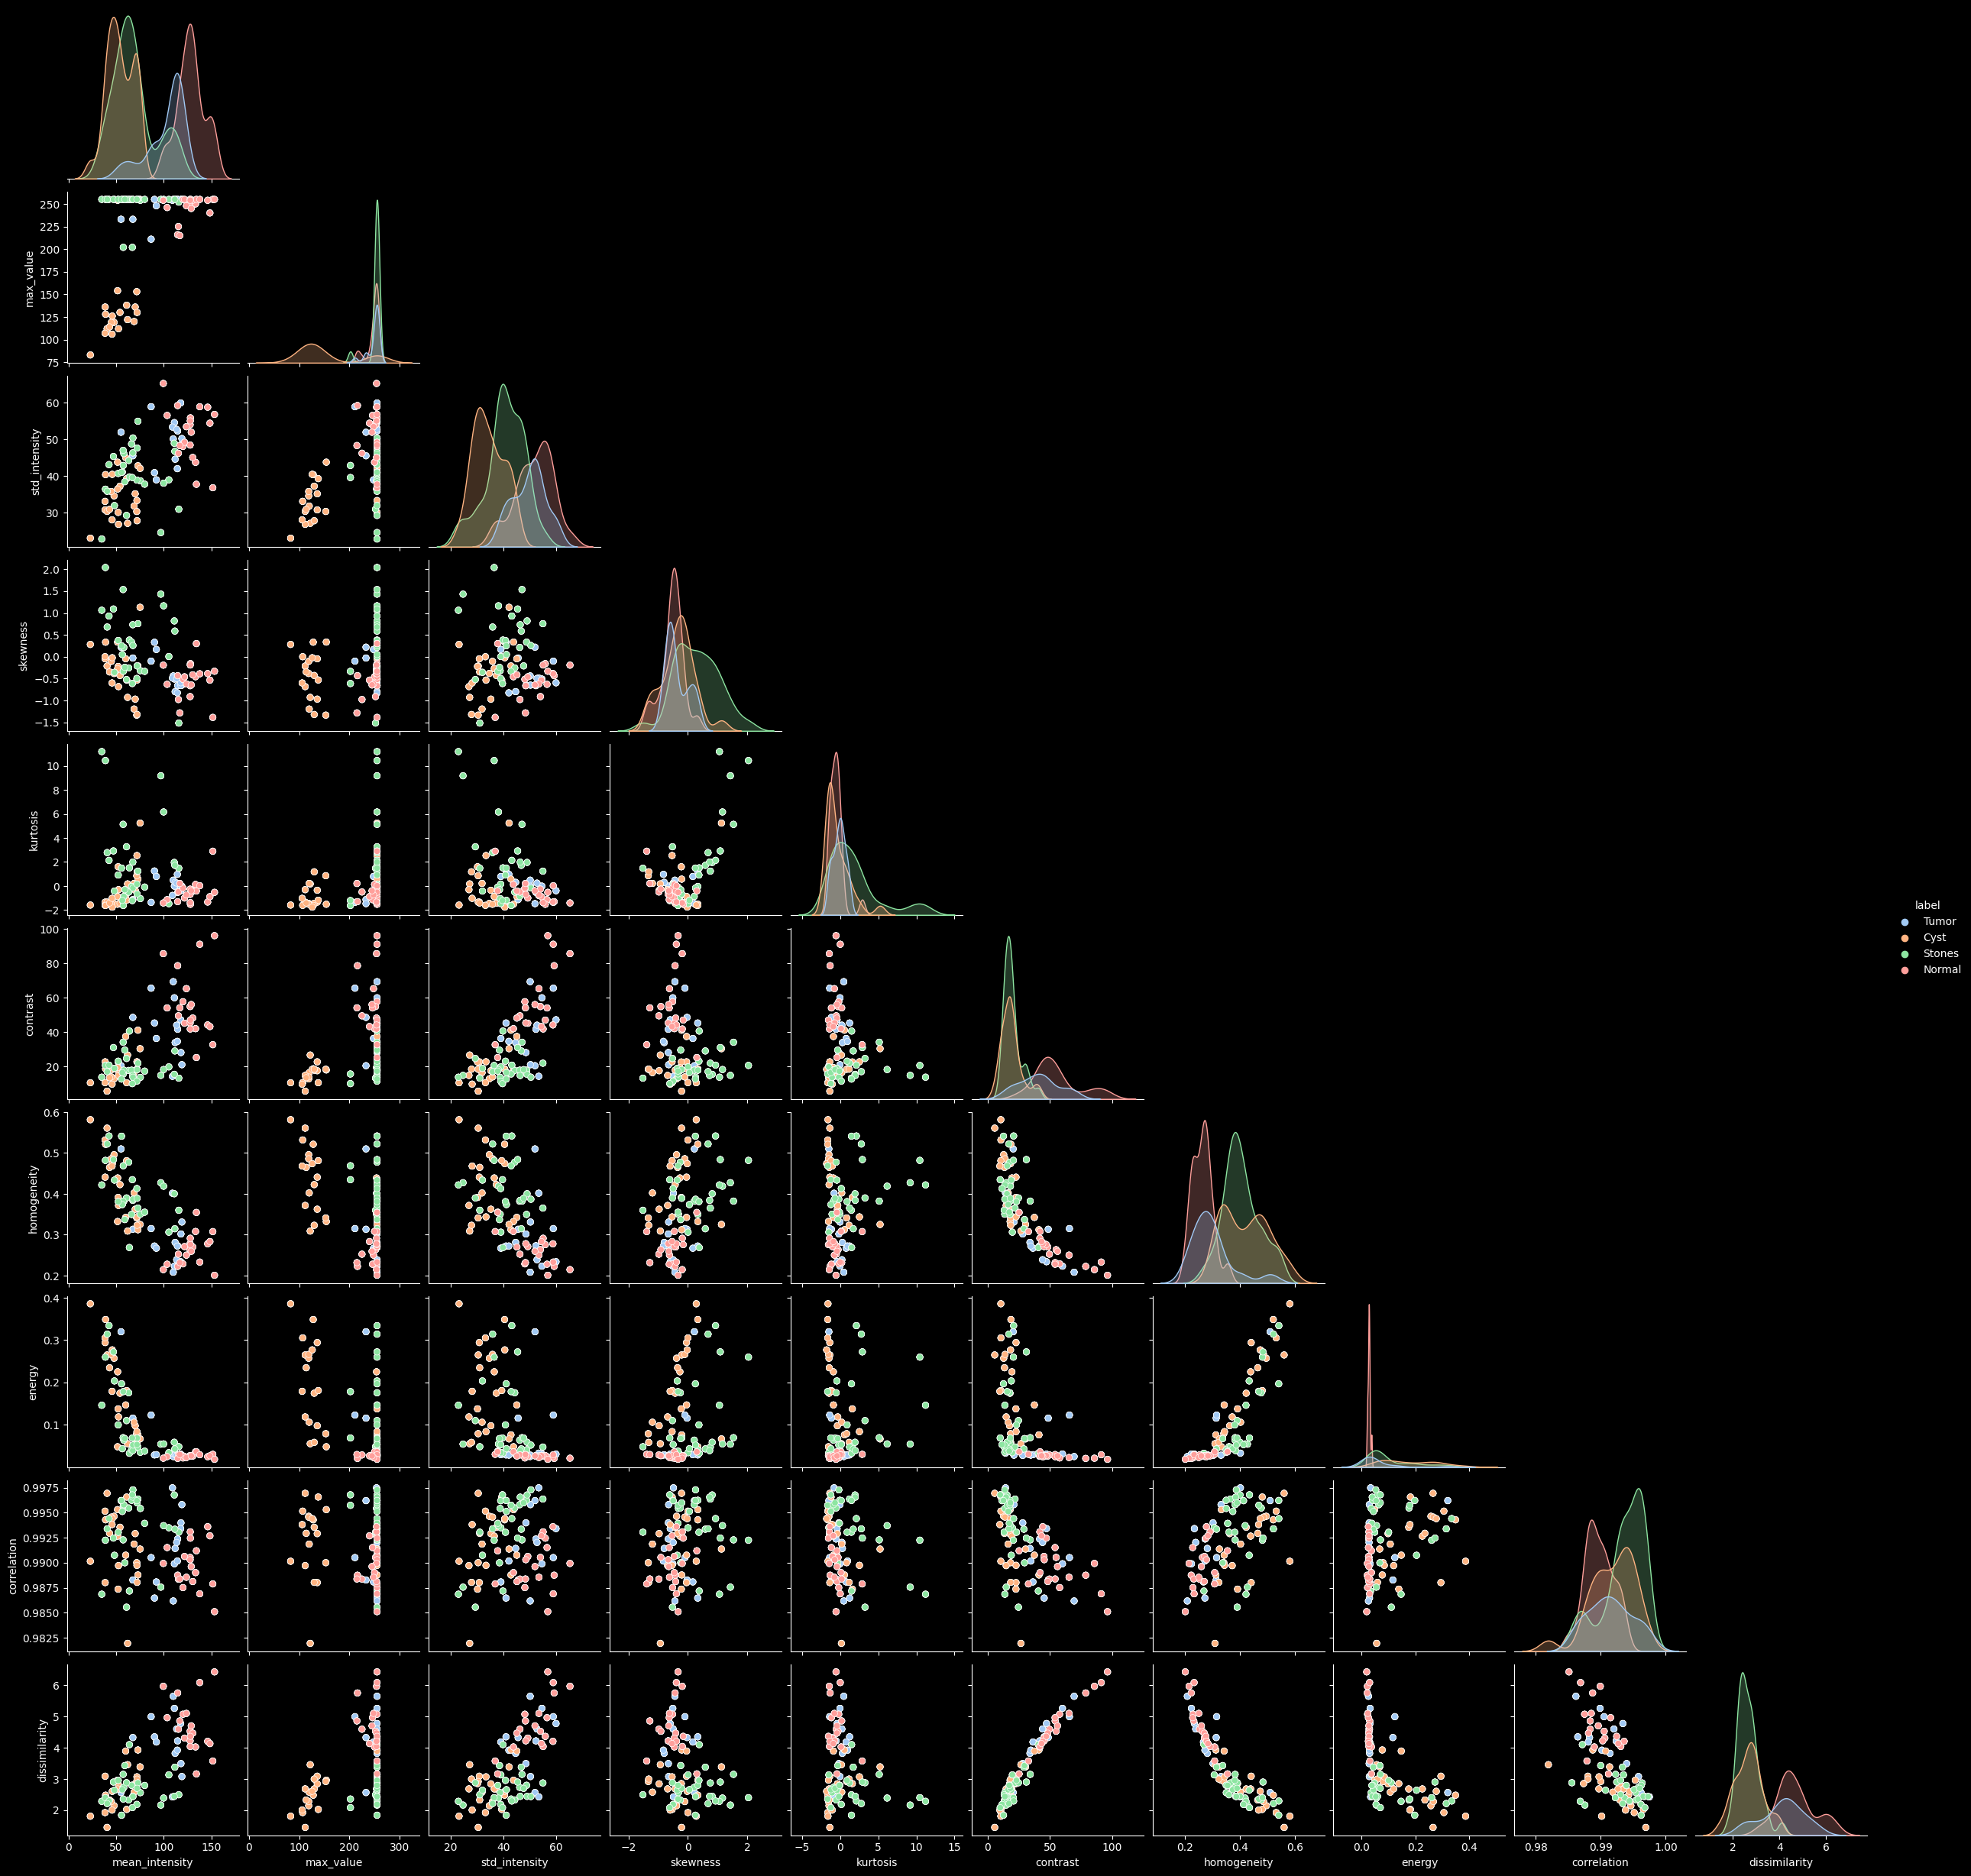

In [ ]:
sns.pairplot(df, hue = 'label', palette = 'pastel', corner = True);

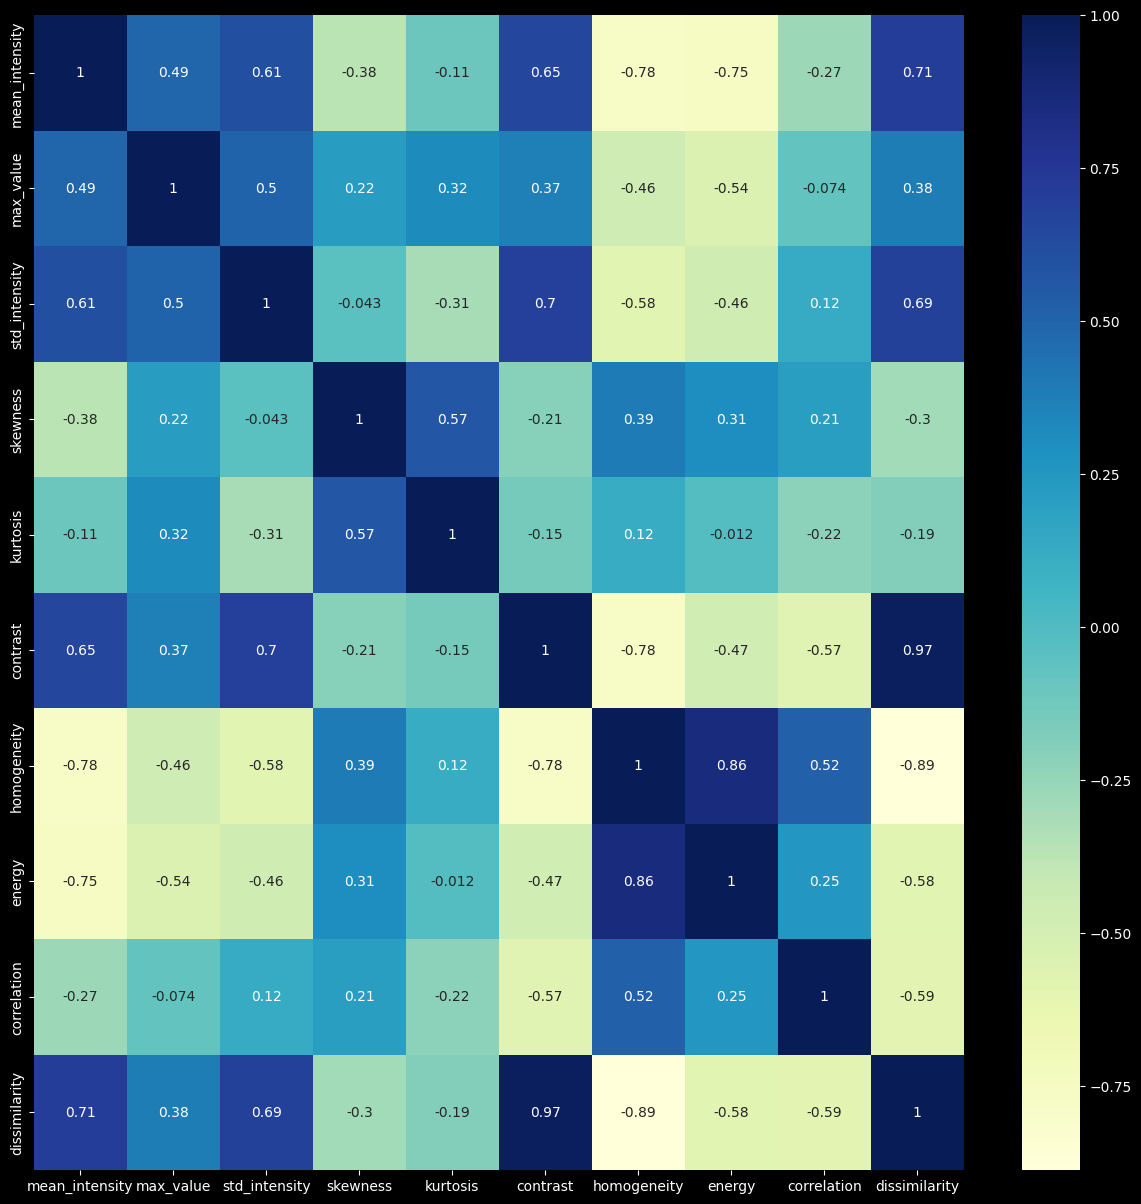

In [ ]:
corr = df[df.columns].corr(numeric_only = True)
plt.figure(figsize=(15,15))
sns.heatmap(corr, cmap="YlGnBu", annot=True);

### Tamaño

Además, se analizan otras variables como por ejemplo cantidad de píxeles adyacentes blancos. Esta métrica resulta particularmente útil al momento de clasificar cálculos renales, que se presentan como pequeñas secciones redondas y blancas.

## Entrenamiento Modelos de ML

In [15]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.svm import SVC
from sklearn.linear_model import Perceptron
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.preprocessing import LabelEncoder

In [16]:
X = df.drop(['label'], axis = 1)
y = df['label']

# Encode categorical labels to numerical values
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

random_state = 13 # para asegurar reproducibilidad de los resultados
ts = 0.3 # test size, el estandar es 30% de la base de datos

xtrain, xtest, ytrain, ytest = train_test_split(X, y_encoded, random_state=random_state, test_size=ts)
print(f'Training on {ytrain.size} examples')

Training on 257 examples


In [17]:
model_lbls = ['dt', 'svc', 'knn', 'rf', 'adb']

# Set the parameters by cross-validation
tuned_param_dt = [{'max_depth': [*range(1,20)]}]
tuned_param_svc = [{'kernel': ['rbf'],
                    'gamma': [1e-1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-6],
                    'C': [1, 10, 100, 1000, 10000],
                    },
                    {'kernel': ['linear'],
                     'C': [1, 10, 100, 1000],
                    },
                   ]
tuned_param_knn =[{'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]}]
tuned_param_rf = [{'max_depth': [*range(5,15)],
                   'n_estimators':[*range(10,100,10)]}]
tuned_param_adb = [{'n_estimators':[20,30,40,50],
                   'learning_rate':[0.5,0.75,1,1.25,1.5]}]

models = {
    'dt': {'name': 'Decision Tree',
           'estimator': DecisionTreeClassifier(),
           'param': tuned_param_dt,
          },
    'svc':{'name': 'Support Vector',
           'estimator': SVC(probability = True),
           'param': tuned_param_svc
          },
    'knn':{'name': 'K Nearest Neighbor',
           'estimator': KNeighborsClassifier(),
           'param': tuned_param_knn
       },
    'rf': {'name': 'Random forest',
           'estimator': RandomForestClassifier(),
           'param': tuned_param_rf
          },
    'adb':{'name': 'AdaBoost           ',
           'estimator': AdaBoostClassifier(),
           'param': tuned_param_adb
          },

}

scores = ['precision_macro', 'recall_macro']

def print_results(model):
    print("Best parameters set found on train set:")
    print()
    # if best is linear there is no gamma parameter
    print(model.best_params_)
    print()
    print("Grid scores on train set:")
    print()
    means = model.cv_results_['mean_test_score']
    stds = model.cv_results_['std_test_score']
    params = model.cv_results_['params']
    for mean, std, params_tuple in zip(means, stds, params):
        print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params_tuple))
    print()
    print("Detailed classification report for the best parameter set:")
    print()
    print("The model is trained on the full train set.")
    print("The scores are computed on the full test set.")
    print()
    y_true, y_pred = ytest, model.predict(xtest)
    print(classification_report(y_true, y_pred))
    print()

In [18]:
best_scores = {}

for key in model_lbls:
  #models[key]['estimator'].fit(xtrain,ytrain)
  #predictions = models[key]['estimator'].predict(xtest)
  grid = GridSearchCV(estimator=models[key]['estimator'], param_grid=models[key]['param'], refit = scores)
  grid.fit(xtrain,ytrain)
  #grid_predictions = grid.predict(xtest)
  print('Trying model '+ models[key]['name'])
  print_results(grid)
  best_scores.update( {key : grid.best_score_} )

print('--------------')
print('Dictionary with best scores:')
print(best_scores)

Trying model Decision Tree
Best parameters set found on train set:

{'max_depth': 9}

Grid scores on train set:

0.549 (+/-0.051) for {'max_depth': 1}
0.805 (+/-0.089) for {'max_depth': 2}
0.852 (+/-0.055) for {'max_depth': 3}
0.914 (+/-0.072) for {'max_depth': 4}
0.926 (+/-0.071) for {'max_depth': 5}
0.945 (+/-0.115) for {'max_depth': 6}
0.981 (+/-0.042) for {'max_depth': 7}
0.981 (+/-0.042) for {'max_depth': 8}
0.996 (+/-0.016) for {'max_depth': 9}
0.996 (+/-0.016) for {'max_depth': 10}
0.996 (+/-0.016) for {'max_depth': 11}
0.996 (+/-0.016) for {'max_depth': 12}
0.996 (+/-0.016) for {'max_depth': 13}
0.996 (+/-0.016) for {'max_depth': 14}
0.996 (+/-0.016) for {'max_depth': 15}
0.996 (+/-0.016) for {'max_depth': 16}
0.996 (+/-0.016) for {'max_depth': 17}
0.996 (+/-0.016) for {'max_depth': 18}
0.996 (+/-0.016) for {'max_depth': 19}

Detailed classification report for the best parameter set:

The model is trained on the full train set.
The scores are computed on the full test set.

   

In [44]:
from sklearn.metrics import classification_report, multilabel_confusion_matrix, ConfusionMatrixDisplay

dt = DecisionTreeClassifier(max_depth = 3)
dt.fit(xtrain, ytrain)

# Predict probabilities on the test set
y_prob_test = dt.predict_proba(xtest)

# Convert probabilities to predicted labels
y_pred_test = dt.predict(xtest)

acc = accuracy_score(ytest, y_pred_test)
print(f'The accuracy on the testing set is {round(acc*100, 2)}%')

The accuracy on the testing set is 84.68%


In [45]:
print(classification_report(ytest, y_pred_test))

              precision    recall  f1-score   support

           0       1.00      0.74      0.85        38
           1       0.91      0.87      0.89        23
           2       0.74      1.00      0.85        32
           3       0.78      0.78      0.78        18

    accuracy                           0.85       111
   macro avg       0.86      0.85      0.84       111
weighted avg       0.87      0.85      0.85       111



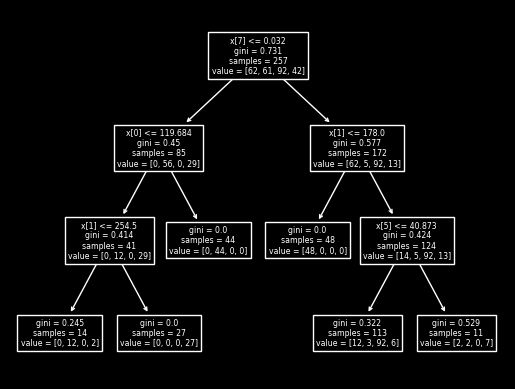

In [52]:
from sklearn import tree

tree.plot_tree(dt)
plt.show()

Confusion matrix, without normalization
[[28  0  8  2]
 [ 0 20  1  2]
 [ 0  0 32  0]
 [ 0  2  2 14]]
Normalized confusion matrix
[[0.73684211 0.         0.21052632 0.05263158]
 [0.         0.86956522 0.04347826 0.08695652]
 [0.         0.         1.         0.        ]
 [0.         0.11111111 0.11111111 0.77777778]]


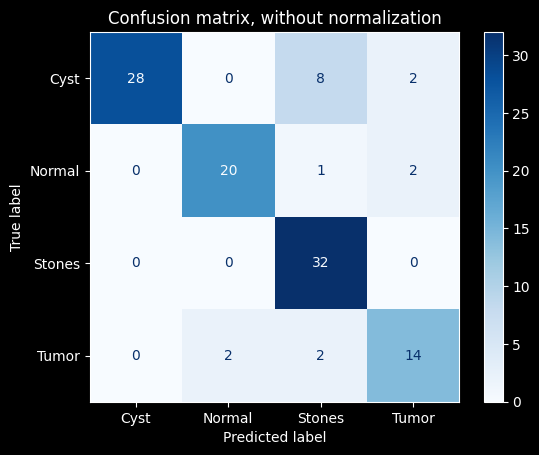

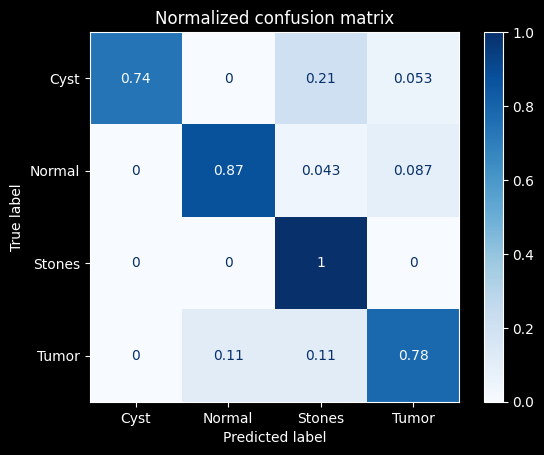

In [53]:
titles_options = [
    ("Confusion matrix, without normalization", None),
    ("Normalized confusion matrix", "true"),
]
for title, normalize in titles_options:
    disp = ConfusionMatrixDisplay.from_estimator(
        dt,
        xtest,
        ytest,
        display_labels=label_encoder.classes_,
        cmap=plt.cm.Blues,
        normalize=normalize,
    )
    disp.ax_.set_title(title)

    print(title)
    print(disp.confusion_matrix)

plt.show()

## Alimentar con nuevos datos

In [29]:
new_img_path = '/content/drive/MyDrive/TP PIB/archive/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone'
test_img_norm = img = cv2.imread(f'{new_img_path}/test_img.png', cv2.IMREAD_GRAYSCALE)
test_img_stone = img = cv2.imread(f'{new_img_path}/test_img2.png', cv2.IMREAD_GRAYSCALE)
test_img_tumor = img = cv2.imread(f'{new_img_path}/test_img3.png', cv2.IMREAD_GRAYSCALE)
test_img_cyst = img = cv2.imread(f'{new_img_path}/test_img4.png', cv2.IMREAD_GRAYSCALE)


def new_data_point(img):

  data = []

  # Segment image
  img_seg_kmeans = segmentar(img, 1)
  seg_gray = bin2gray(img_seg_kmeans, img)

  # Extract image features
  features = extract_features(img)
  data.append(features)

  # Create dataframe
  x_new = pd.DataFrame(data)

  return x_new

def predict_probabilities(img, trained_model, classes):

  x = new_data_point(img)
  test_label_probabilities = trained_model.predict_proba(x)

  print('Diagnosis probabilities:')
  for i, classif in enumerate(classes):
    print(f'{classif}: {round(test_label_probabilities[0][i]*100,2)}%')



In [48]:
predict_probabilities(test_img_norm, dt, label_encoder.classes_)

Diagnosis probabilities:
Cyst: 0.0%
Normal: 85.71%
Stones: 0.0%
Tumor: 14.29%


In [49]:
predict_probabilities(test_img_stone, dt, label_encoder.classes_)

Diagnosis probabilities:
Cyst: 10.62%
Normal: 2.65%
Stones: 81.42%
Tumor: 5.31%


In [50]:
predict_probabilities(test_img_tumor, dt, label_encoder.classes_)

Diagnosis probabilities:
Cyst: 0.0%
Normal: 0.0%
Stones: 0.0%
Tumor: 100.0%


In [51]:
predict_probabilities(test_img_cyst, dt, label_encoder.classes_)

Diagnosis probabilities:
Cyst: 18.18%
Normal: 18.18%
Stones: 0.0%
Tumor: 63.64%


Exportamos el classifier

## Conclusiones

Se concluye que se logra clasificar efectivamente las distintas clases.

## Pasos a seguir

Coming soon ;)

- [x] Mejoramiento de las imágenes seleccionadas
- [x] Segmentación
- [ ] Análisis de texturas locales
- [ ] Elección de algoritmo de ML supervisado. Candidatos:
  - SVM
  - KNN
  - DT
  - RF
  - NN
- [ ] Comparación de algoritmos y resultados

# Anexo / posible trash

In [ ]:
'''
def calculate_mean_color(image_path):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    mean_color = np.mean(img)
    return mean_color

def process_images_in_folder(folder_path):
    class_intensity_means = {}
    for subdir, _, files in os.walk(folder_path):
      for file in files:
        image_path = os.path.join(subdir, file)
        class_name = os.path.basename(subdir)
        img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        histogram = cv2.calcHist([img], [0], None, [256], [0, 256])
        normalized_hist = histogram / np.sum(histogram)
        if class_name not in class_intensity_means:
            class_intensity_means[class_name] = []
        intensity_mean = calculate_mean_color(image_path)
        intensity_density = normalized_hist[int(intensity_mean)]
        class_intensity_means[class_name].append([intensity_mean,intensity_density])
    return class_intensity_means

class_color_means = process_images_in_folder(path)
'''

In [ ]:
def filtro_gaussiano_imagen(img, kernel_size, sigma):
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), sigma)

filtered_normal = []

all_item_dirs = os.listdir(path_normal_filt)
item_files = [os.path.join(path_normal_filt, file) for file in all_item_dirs]

for idx, img_path in enumerate(item_files):
  image = cv2.imread(img_path, 0)
  filt_img = filtro_gaussiano_imagen(image, 5, 1)
  filtered_normal.append(filt_img)